<a href="https://colab.research.google.com/github/jagadish9084/learnbay-ds-ml-course/blob/main/ml_models/supervised/ensemble/ada_boost/diabetes_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement and data dictionaries

### Problem statement


The increasing prevalence of diabetes necessitates effective tools for early diagnosis and prevention. This dataset offers a valuable opportunity to predict the onset of diabetes in female patients based on 8 health-related attributes derived from medical diagnostic measurements. With 768 patient records and an Outcome variable indicating the presence (1) or absence (0) of diabetes, this dataset serves as a foundation for developing and evaluating machine learning classification models. The goal is to utilize this data to build predictive models that can assist healthcare professionals in identifying individuals at risk and implementing timely interventions

### Data dictionary

- **Pregnancies:** Number of times the patient has been pregnant.
- **Glucose:** Plasma glucose concentration after a 2-hour oral glucose tolerance test.
- **BloodPressure:** Diastolic blood pressure (mm Hg).
- **SkinThickness:** Triceps skinfold thickness (mm).
- **Insulin:** 2-hour serum insulin (mu U/ml).
- **BMI:** Body mass index (weight in kg/(height in m)^2).
- **DiabetesPedigreeFunction:** A function that represents the patient’s diabetes pedigree (i.e., likelihood of diabetes based on family history).
- **Age:** Age of the patient (years).
- **Outcome:** Binary outcome (0 or 1) where 1 indicates the presence of diabetes and 0 indicates the absence.

# Data cleaning and feature engineering

In [1033]:
# Importing liberaries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve
import warnings

warnings.filterwarnings('ignore')
sns.set()

In [1034]:
# Load the data
data = pd.read_csv('/content/sample_data/diabetes_dataset.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [1035]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [1036]:
# Describe
data.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Key Observations:

Glucose, BloodPressure, SkinThickness, Insulin, and BMI have a minimum value of 0, which may indicate missing or invalid data.
The dataset has no explicit null values but contains implied missing values represented as 0

In [1037]:
# Handle missing values
missing_val_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in missing_val_columns:
  mean = data[col].mean()
  data[col] = data[col].apply(lambda a: mean if a <= 0 else a)

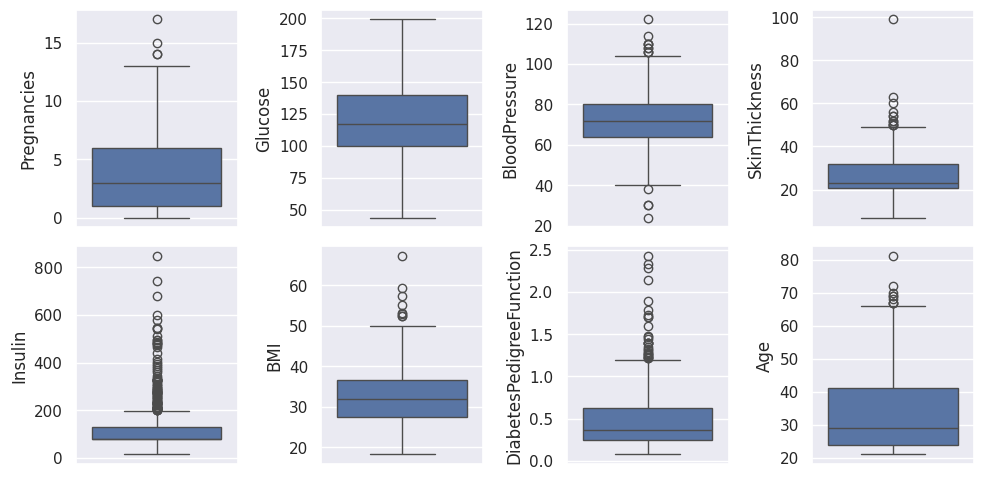

In [1038]:
# Outlier analysis
features = data.drop(['Outcome'], axis=1).columns

def detect_outlier(features):
  figure, ax = plt.subplots(2, 4, figsize=(10, 5))
  for index, col in enumerate(features):
    sns.boxplot(ax=ax[index//4, index%4], data=data[col])
  plt.tight_layout()

detect_outlier(features)

Box plot results indicate that all features have outliers.

In [1039]:
# Outlier Treatment

def outlier_treatement(features):
  for col in features:
    q1 = data[col].quantile(.25)
    q3 = data[col].quantile(.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    data[col].clip(lower_fence, upper_fence, inplace=True)

outlier_treatement(features)


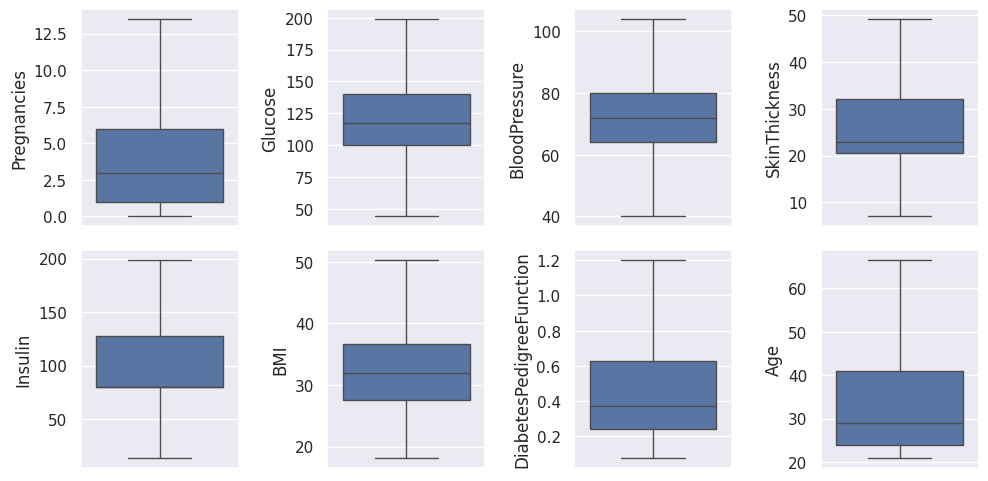

In [1040]:
# Verfiy outlier treatement
detect_outlier(features)

As we can see from the box plot above, outlier is handled for all the features.

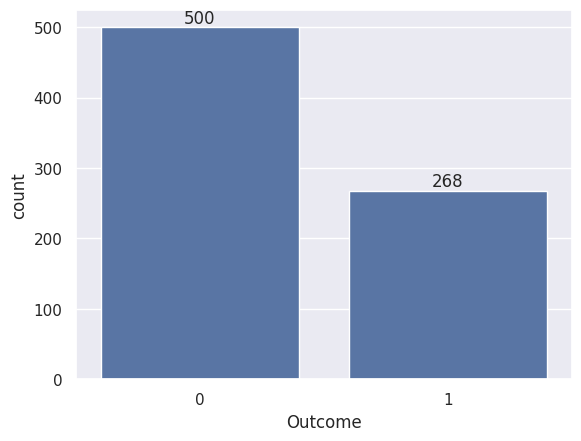

In [1041]:
# Check data balancing
ax = sns.countplot(data=data, x ='Outcome')
plt.bar_label(ax.containers[0])
plt.show()

In [1042]:
# Segregate feature and target
X = data.drop(['Outcome'], axis=1)
y = data[['Outcome']]
print(f"Dimention of features: {X.shape}")
print(f"Dimention of target: {y.shape}")

Dimention of features: (768, 8)
Dimention of target: (768, 1)


In [1043]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Dimention of X_train: {X_train.shape}")
print(f"Dimention of X_test: {X_test.shape}")
print(f"Dimention of y_train: {y_train.shape}")
print(f"Dimention of y_test: {y_test.shape}")

Dimention of X_train: (576, 8)
Dimention of X_test: (192, 8)
Dimention of y_train: (576, 1)
Dimention of y_test: (192, 1)


# Build Adaboost Base model

In [1044]:
# Build Adaboost base model
model = AdaBoostClassifier().fit(X=X_train, y=y_train)

# Evaluate
def evaluate(y_true, y_pred):
  print(f"Classification reports for ada boost:\n\n{classification_report(y_true, y_pred)}")
  cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)


Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       377
           1       0.79      0.73      0.76       199

    accuracy                           0.84       576
   macro avg       0.83      0.82      0.82       576
weighted avg       0.84      0.84      0.84       576



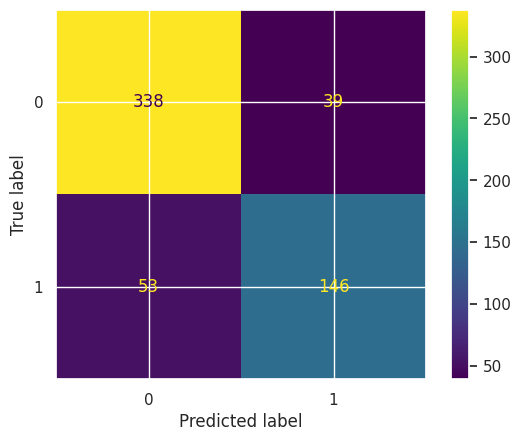

In [1045]:
# Evaluation of training result
y_train_pred = model.predict(X_train)
evaluate(y_train, y_train_pred)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       123
           1       0.58      0.61      0.60        69

    accuracy                           0.70       192
   macro avg       0.68      0.68      0.68       192
weighted avg       0.71      0.70      0.70       192



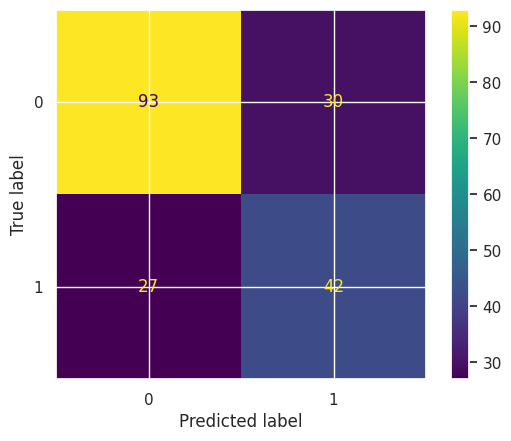

In [1046]:
# Evaluation of test results
y_test_pred = model.predict(X_test)
evaluate(y_test, y_test_pred)

Conclusion:

1. Recall importance for diabetics predictions:
   - Recall is crucial for biebetics predictions since it measures the model abilities to correctly identify positive cases.
   - In healthcase false negative(not detecting when patient has diabetic) are more crucial than false positive.

2. Performance on training vs Testing sets:
   - Training performance are better than testing, indicating overfitting
   - This happens when the model learns the training data pattern too well and fails to generalize to unseen data

3. Bias toward class 0:
   - The model shows clear bias towards class 0, as evident from its higher precision, recall and F-1 score compare to class 1.
   - This bias indicate that the model performs better for class 0, likely due to the data imbalance.

Next Course of Actions

1. Address data imbalance using one of the below techniques:
   - Oversampling minority class
   - Under sampling majority class
   - Class weighting in AdaBoost to assign higher importance to class 1
2. Improve model generalization to reduce overfitting:
   - Tune hyper parameter(no enstimators and learning rate)
   - Cross validations

# Address Class Imbalance

## SMOTE (Synthetic Minority Oversampling Technique)

Important points:

Over sampling should only be applied to training set for the following reason:

- To avoid data leakage
- To Mimic real work scenario

SMOTE uses distance based metrics(ex: Euclidean distance) to generate synthetic samples for minority class. If features have different scales will dominate the distance calculation, leading to biased synthetic samples. Scaling ensures all features contributes equally to the distance metric used by SMOTE.

Even though SMOTE is not applied to the the testing set, it is essential to scale test data to maintain consistancy with scaled training data during model evaluation.

The test set must be scaled with the same scalar which ensures that the test data transformed in constant with the trained data.

In [1047]:
# Over sampling using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

# Feature scaling
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

smote = SMOTE(random_state=42)

X_train_over_sampled, y_train_over_sampled= smote.fit_resample(X_train_scaled, y_train)
print(f"Dimention of X_train over sampling : {X_train_over_sampled.shape}")
print(f"Dimention of y_train over sampling : {y_train_over_sampled.shape}")

Dimention of X_train over sampling : (754, 8)
Dimention of y_train over sampling : (754, 1)


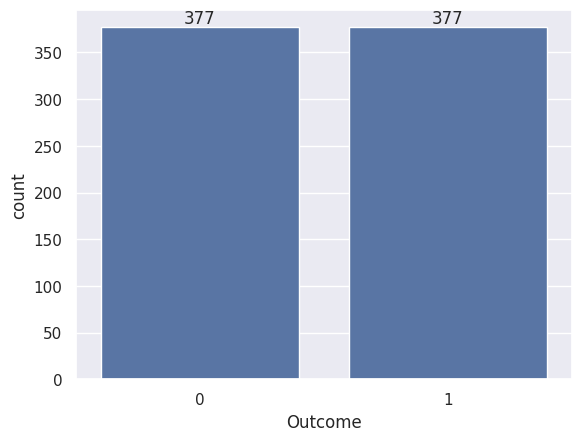

In [1048]:
# Check data balancing
ax = sns.countplot(data=y_train_over_sampled, x ='Outcome')
plt.bar_label(ax.containers[0])
plt.show()

In [1049]:
# Model Training
ada_model = AdaBoostClassifier()
ada_model.fit(X_train_over_sampled, y_train_over_sampled)

AdaBoostClassifier()

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       377
           1       0.83      0.88      0.86       377

    accuracy                           0.85       754
   macro avg       0.85      0.85      0.85       754
weighted avg       0.85      0.85      0.85       754



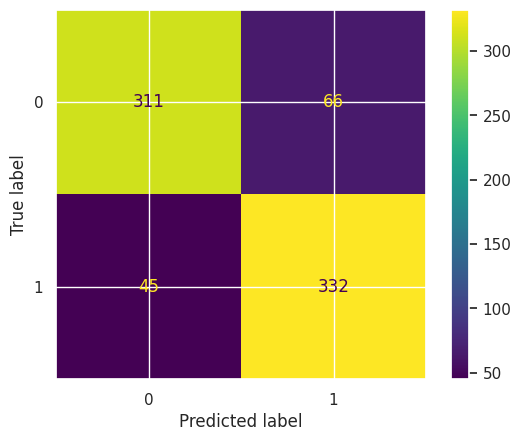

In [1050]:
# Evaluate Training performance
y_train_pred = ada_model.predict(X_train_over_sampled)
evaluate(y_train_over_sampled, y_train_pred)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.81      0.71      0.75       123
           1       0.57      0.70      0.63        69

    accuracy                           0.70       192
   macro avg       0.69      0.70      0.69       192
weighted avg       0.72      0.70      0.71       192



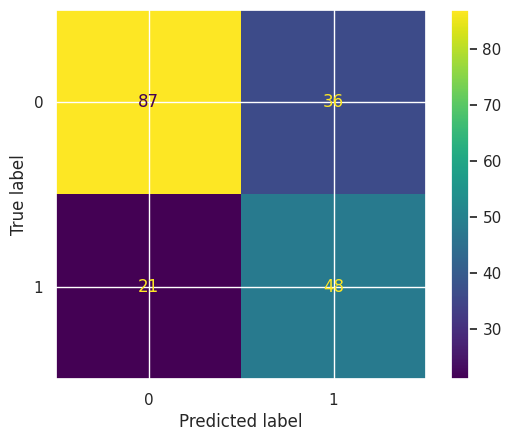

In [1051]:
# Evaluation of test results
y_test_pred = ada_model.predict(X_test_scaled)
evaluate(y_test, y_test_pred)

Conclusion

1. Good Training Performance
   - The model is performing well for both the classes on training data after SMOTE.
   - This indicates that the oversampling with SMOTE has successfully balanced the training data, allowing the model to learn patterns for the both the classes effectively.

2. Bias toward majority class on test data
   - Even though the recall for both the classes are similar, The Test performance still shows that higher precision and F1 score for class 0 which suggest that the bias toward the majority class in test data.


## RandomUnderSampler

In [1052]:
### Under sampling
from imblearn.under_sampling import RandomUnderSampler

X_train_us, y_train_us = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print(f"Dimention of X_train_us: {X_train_us.shape}")
print(f"Dimention of y_train_us: {y_train_us.shape}")

Dimention of X_train_us: (398, 8)
Dimention of y_train_us: (398, 1)


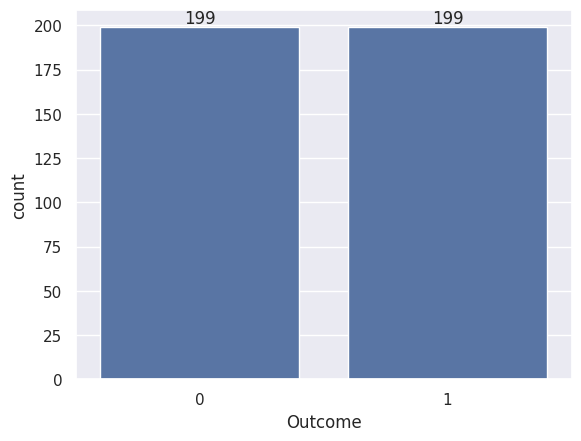

In [1053]:
# Check data balancing
ax = sns.countplot(data=y_train_us, x ='Outcome')
plt.bar_label(ax.containers[0])
plt.show()

In [1054]:
### Model training
ada_model = AdaBoostClassifier(random_state=42).fit(X_train_us, y_train_us)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       199
           1       0.84      0.84      0.84       199

    accuracy                           0.84       398
   macro avg       0.84      0.84      0.84       398
weighted avg       0.84      0.84      0.84       398



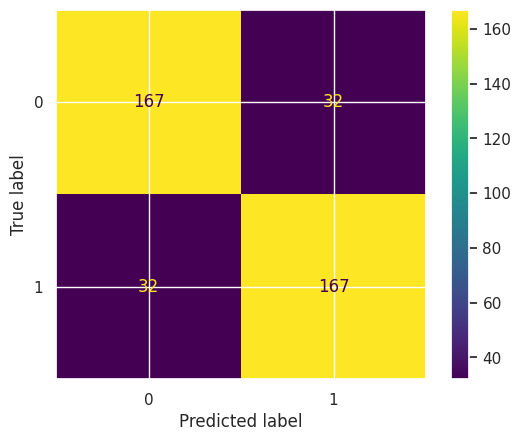

In [1055]:
# Evaluate Training performance
y_train_pred = ada_model.predict(X_train_us)
evaluate(y_train_us, y_train_pred)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       123
           1       0.54      0.74      0.62        69

    accuracy                           0.68       192
   macro avg       0.68      0.69      0.67       192
weighted avg       0.71      0.68      0.68       192



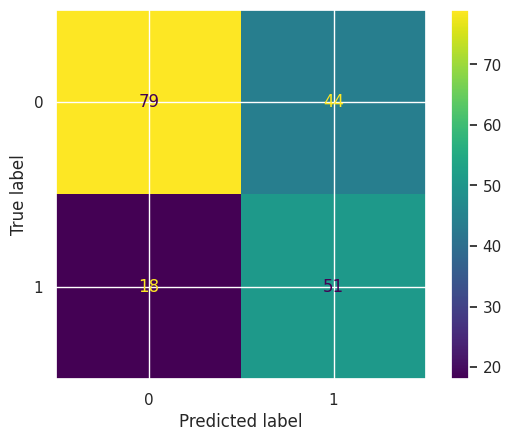

In [1056]:
# Evaluation of test results
y_test_pred = ada_model.predict(X_test)
evaluate(y_test, y_test_pred)

Conclusion

    Under sampling the majority classes using RandomUnderSampler yeild good result on training data but could not perform well on test data.
    Test performance still shows that higher precision and F1 score for class 0 and higher recall for class 1 which suggest that the bias toward the majority class(precision and F1) in test data.

## SMOTE-ENN

Dimenstion of X_train_se:(614, 8)
Dimenstion of y_train_se:(614, 1)


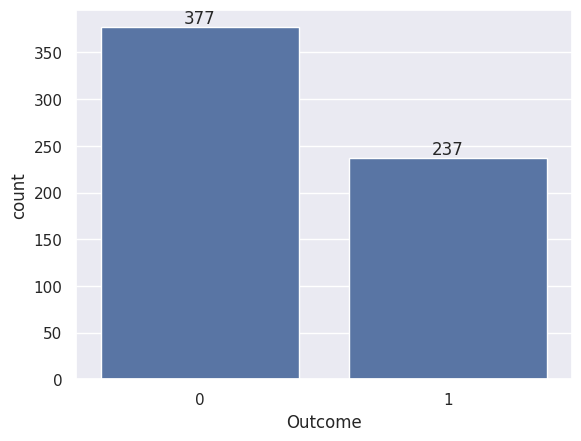

In [1057]:
# Balancing

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Balancing
smote_enn = SMOTEENN(smote=SMOTE(sampling_strategy='auto', k_neighbors=3), random_state=42, enn=EditedNearestNeighbours(n_neighbors=3))
X_train_se, y_train_se = smote_enn.fit_resample(X_train_scaled, y_train)
print(f"Dimenstion of X_train_se:{X_train_se.shape}")
print(f"Dimenstion of y_train_se:{y_train_se.shape}")

# Plot
ax = sns.countplot(data=y_train_se, x ='Outcome')
plt.bar_label(ax.containers[0])
plt.show()

In [1058]:
### Model training
ada_model = AdaBoostClassifier(random_state=42).fit(X_train_se, y_train_se )

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       377
           1       0.86      0.88      0.87       237

    accuracy                           0.90       614
   macro avg       0.89      0.90      0.89       614
weighted avg       0.90      0.90      0.90       614



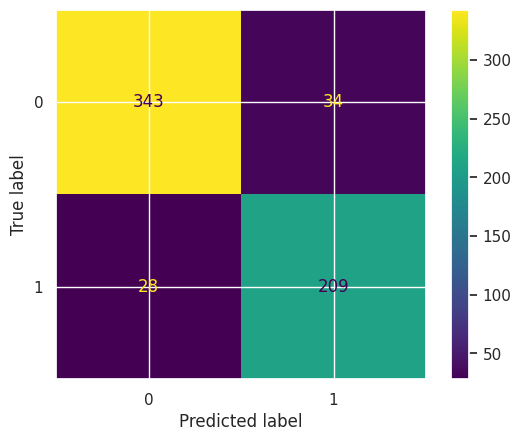

In [1059]:
# Evaluate Training performance
y_train_pred = ada_model.predict(X_train_se)
evaluate(y_train_se, y_train_pred)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       123
           1       0.68      0.55      0.61        69

    accuracy                           0.74       192
   macro avg       0.73      0.70      0.71       192
weighted avg       0.74      0.74      0.74       192



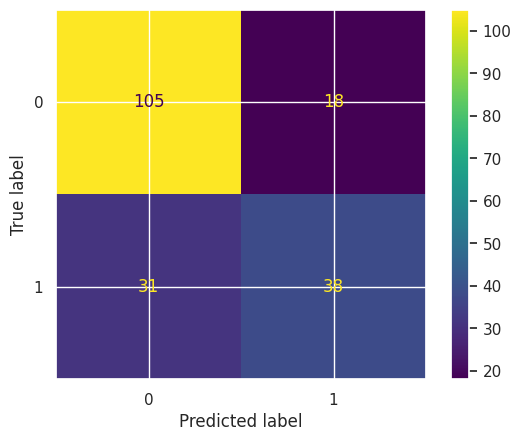

In [1060]:
# Evaluate Training performance
y_test_pred = ada_model.predict(X_test_scaled)
evaluate(y_test, y_test_pred)

Conclusion:
1. Training Performance:
  - The model performs very well on the training data, with high and balanced scores for both majority and minority classes.
  - No significant bias toward the majority class is observed in the training set.

2. Testing Performance:
  - On the test set, the minority class (Class 1) has lower precision , recall , and F1-score.
  - This suggests the model may overfit the training data, as it struggles to generalize well to unseen data, especially for the minority class.

3. Overall:
  - The recall and F1-score for the minority class on the test set are significantly lower than the majority class, indicating a need for improved generalization and handling of class imbalance.


## Address Class Imbalance by using Class Weighting

In [1061]:
# Create estimatator which assign higher weight to class 1
decision_stump = DecisionTreeClassifier(max_depth=1, class_weight={0:1, 1: 2})
ada_boost_weighted = AdaBoostClassifier(estimator=decision_stump, n_estimators=50).fit(X_train, y_train)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       377
           1       0.71      0.87      0.78       199

    accuracy                           0.83       576
   macro avg       0.82      0.84      0.82       576
weighted avg       0.85      0.83      0.83       576



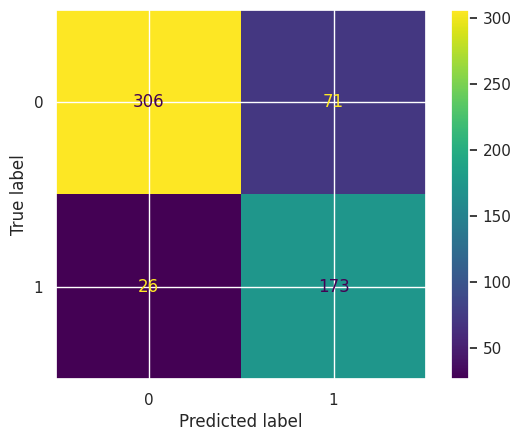

In [1062]:
# Evaluation of training result
y_train_pred = ada_boost_weighted.predict(X_train)
evaluate(y_train, y_train_pred)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       123
           1       0.64      0.77      0.70        69

    accuracy                           0.76       192
   macro avg       0.75      0.76      0.75       192
weighted avg       0.78      0.76      0.76       192



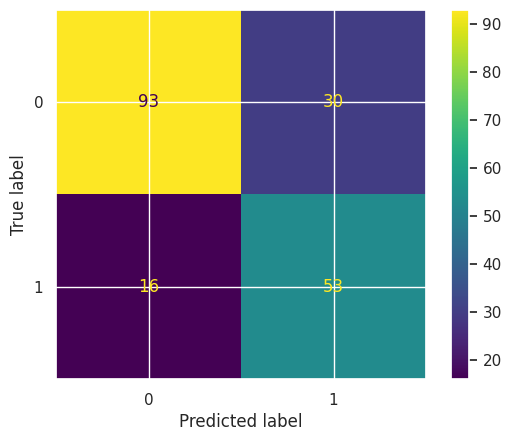

In [1063]:
# Evaluation of training result
y_test_pred = ada_boost_weighted.predict(X_test)
evaluate(y_test, y_test_pred)

Training Performance:
  - Precision, recall, and F1-score are good for the majority class (class 0), while the minority class (class 1) has good recall  but lower precision and F1-score.
  - The model shows some bias toward the majority class in terms of prediction confidence (precision and F1-score), but it is relatively good at detecting positive cases (recall for both classes).


Testing Performance:

  - The model performs worse on the test set compared to the training set, indicating some overfitting.
  - Precision and F1-score for the minority class (class 1) are lower than for the majority class, suggesting bias in prediction confidence for class 1.
  - However, recall for the minority class is comparable to the majority class, indicating the model is reasonably good at detecting minority class cases but struggles to predict them confidently.

# Hyper Parameter tuning

## Hyper Parameter tuning with Class Weight
Model with Class Imbalance addressed using Class Weighting techniques gives better result compared to other models. Hence, lets use this model for hyper parameter tuning.

In [1064]:
# Import libs
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.1, 0.5, 1.0],
    "estimator__max_depth": [1, 2],
    "estimator__class_weight": [{0:1, 1: 2}, {0:1, 1: 3}]
}

base_estimator = DecisionTreeClassifier()
ada_boost = AdaBoostClassifier(estimator=base_estimator, random_state=42)

grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, cv=5, n_jobs=-1, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'estimator__class_weight': [{0: 1, 1: 2},
                                                     {0: 1, 1: 3}],
                         'estimator__max_depth': [1, 2],
                         'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150]},
             scoring='recall')

In [1065]:
#
print(f"Best paramaters: {grid_search.best_params_}")

Best paramaters: {'estimator__class_weight': {0: 1, 1: 3}, 'estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}


In [1066]:
# Build the model with best parameters
base_estimator = DecisionTreeClassifier( max_depth=1)
ada_boost = AdaBoostClassifier(estimator=base_estimator, learning_rate=1,n_estimators=50, random_state=42)
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, random_state=42)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       377
           1       0.71      0.87      0.78       199

    accuracy                           0.83       576
   macro avg       0.82      0.84      0.82       576
weighted avg       0.85      0.83      0.83       576



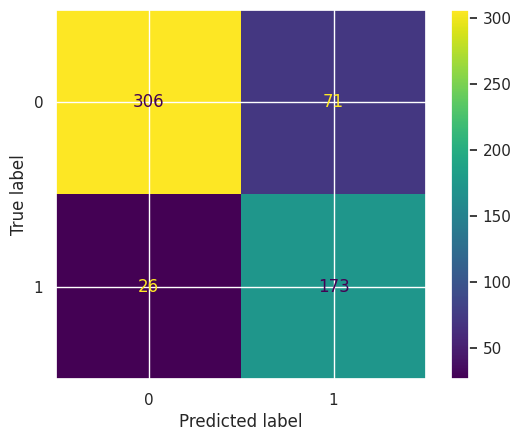

In [1067]:
# Evaluation of training result
y_train_pred = ada_boost_weighted.predict(X_train)
evaluate(y_train, y_train_pred)

Classification reports for ada boost:

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       123
           1       0.64      0.77      0.70        69

    accuracy                           0.76       192
   macro avg       0.75      0.76      0.75       192
weighted avg       0.78      0.76      0.76       192



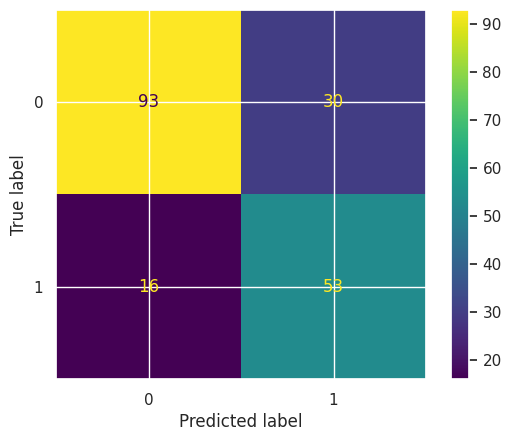

In [1068]:
# Evaluation of test result
y_test_pred = ada_boost_weighted.predict(X_test)
evaluate(y_test, y_test_pred)